### Local Multimodal with Weaviate <img src="https://weaviate.io/img/site/weaviate-logo-light.png" alt="Weaviate Logo" width="40"/>

<h5> - Build Text and Image Search through vector spaces using weaviate vector database locally </h5>
<h5> - Built with FIFA 22 Data (https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset)</h5>

#### Setup Packages and Weaviate (Additional: Docker)

In [3]:
# Importing Necessary Packages
import warnings
from PIL import Image
import requests
import io
from pathlib import Path
import base64

import weaviate
from weaviate.classes.config import Configure, DataType, Property
from weaviate.util import generate_uuid5
from weaviate.classes.query import MetadataQuery

from IPython.display import Image as IPYImage

import pandas as pd

In [4]:
warnings.filterwarnings("ignore")

#### Connecting to Weaviate

In [5]:
# Check and Close Close Client Already Open First
#client.close()

In [6]:
client = weaviate.connect_to_local()

print(client.is_ready())

True


In [7]:
meta_info = client.get_meta()
print(meta_info)

{'hostname': 'http://[::]:8080', 'modules': {'multi2vec-clip': {'clip_model': {'_commit_hash': None, '_name_or_path': '/root/.cache/torch/sentence_transformers/sentence-transformers_clip-ViT-B-32/0_CLIPModel', 'add_cross_attention': False, 'architectures': ['CLIPModel'], 'bad_words_ids': None, 'begin_suppress_tokens': None, 'bos_token_id': None, 'chunk_size_feed_forward': 0, 'cross_attention_hidden_size': None, 'decoder_start_token_id': None, 'diversity_penalty': 0, 'do_sample': False, 'early_stopping': False, 'encoder_no_repeat_ngram_size': 0, 'eos_token_id': None, 'exponential_decay_length_penalty': None, 'finetuning_task': None, 'forced_bos_token_id': None, 'forced_eos_token_id': None, 'id2label': {'0': 'LABEL_0', '1': 'LABEL_1'}, 'initializer_factor': 1, 'is_decoder': False, 'is_encoder_decoder': False, 'label2id': {'LABEL_0': 0, 'LABEL_1': 1}, 'length_penalty': 1, 'logit_scale_init_value': 2.6592, 'max_length': 20, 'min_length': 0, 'model_type': 'clip', 'no_repeat_ngram_size': 0, 

#### Creating Collection

In [8]:
# Delete the existing collection
client.collections.delete("Players_FIFA")

# Create the new collection
client.collections.create(
    name="Players_FIFA",
    properties=[
        Property(name="short_name", data_type=DataType.TEXT),
        Property(name="player_traits", data_type=DataType.TEXT),
        Property(name="overall", data_type=DataType.NUMBER),
        Property(name="player_position", data_type=DataType.TEXT),
        Property(name="sofifa_id", data_type=DataType.INT),
        Property(name="playerb64", data_type=DataType.BLOB),
        Property(name="player_face_url", data_type=DataType.TEXT),
    ],
    vectorizer_config=[
        # Vectorize the text-based properties for semantic search
        Configure.NamedVectors.text2vec_transformers(
            name="txt_vector",
            source_properties=["short_name", "player_traits", "player_position"],
        ),
        
        # Vectorize the player face images for semantic search
        Configure.NamedVectors.multi2vec_clip(
            name="player_face_vector",
            image_fields=["playerb64"], 
        )
    ]
)


#### Helper Functions

In [16]:
def load_image(url_or_path):
    if url_or_path.startswith("http://") or url_or_path.startswith("https://"):
        return Image.open(requests.get(url_or_path,stream=True).raw)
    else:
        return Image.open(url_or_path)

In [17]:
# Helper function to convert a url to base64 representation

# Note: Can be combined with an If else
def toBase64(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        return base64.b64encode(response.content).decode('utf-8')
    except requests.exceptions.RequestException as e:
        print(f"Error fetching the image from {url}: {e}")
        return None  # Handle missing/invalid URLs gracefully
    
# Helper function to convert a file to base64 representation
def toBase64_path(path):
    with open(path, 'rb') as file:
        return base64.b64encode(file.read()).decode('utf-8')

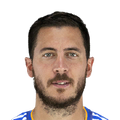

In [18]:
sam_img_url="https://cdn.sofifa.net/players/183/277/22_120.png"
a=load_image(sam_img_url)
a

In [19]:
b=toBase64(sam_img_url)
b

'iVBORw0KGgoAAAANSUhEUgAAAHgAAAB4CAYAAAA5ZDbSAABFn0lEQVR42ux7e6xl11nf71uP/Tpnn9c999659/rOjMf2zPiROJMYB4gDjpPgEAWoRAINohV9oFJa+k+FWtRKbSWQCqRBBalVxKOVaFChFAVUJCCiQm2QTQgQ2wl+ezwz9szcue9zz2PvvV49+9vHowBpRfoH9lzmN1pe5+yz917X67e+b32vhdu4jdu4jdu4jdu4jdu4jdu4jdu4jdu4jeMCiWOK+87dSf1eW6iYaGmpS0vdtji1cYLuPnsn3XPXSdpYW6L1E0uUpRlu4xbDxvqqwNcATRDDTiY3V5fE+fkCwG28NfHg299+k9ivu/DAxpnT639nfX3wibX1wX/YXBv864cePP833/3w2x79yOPve88Hv/nh93/DQ/efvfPkeo4/h0G/I1rttthYXxabm8PbhL9ZuO/8OXH3ubPq/NlzCgv86MXn9Dvecf+3ra8MXl5d6oa1tX7Y2FiyZ89shK97x/nwLY8/Ej70gfeY9z1yITz0jrPFubtPffGOteG/Orm+8s/vPrXx3RceOL+MP4f58+qB++85ttvZWwonlnq0NJcwfBW8/5H3fufp03f+7vrq0u7G6sDdfXqtvPeeTfeN77w/vPvC/fb+c3eZt99/zr77wXP+A1//NvP1D57182vhntOb4dT6ShgOuyHN01c7ndZn1oa9T22s9P/FT/3Mv9V/ZvzVvsAtBOrkOW4hSAAOC5y75+4L+0ejd6Zpet90PH3AGPOI9yFbXUqtUkTeQx4cjEJhKpSlAQURAgKcMXDOo9fJ4YII3tlQOAvrvehkqTg8mqIoLSJNVkj/+Xbe/rlhf/kGgN/EAod7IwHA4y0OWl9fwlsYdHBwiFaa0huTOex2u6NZ+cB0av5uCPhokiUdkhJaSdSMriwNXVkdyfq5yWQWLBxoDkkiEBGMNVBCQQiBqqxQVRUFH0KQAk5K9LIsdNMoTEu

#### Importing Data with Pandas

In [22]:
players_data=pd.read_csv('data/players_22.csv')
players_data.shape

(19239, 83)

In [23]:
players_data=players_data[0:100]
players_data.shape

(100, 83)

#### Importing Text and Image Data into Weaviate in Batches

In [24]:
players_fifa = client.collections.get("Players_FIFA")

with players_fifa.batch.dynamic() as batch:
    # for index, movie in df.sample(20).iterrows():
    for index, player in players_data.iterrows():

        # In case you run it again - Don't import players that are already in.
        if(players_fifa.data.exists(generate_uuid5(player.sofifa_id))):
            print(f'{index}: Skipping insert. The player "{player.short_name}" is already in the database.')
            continue

        print(f'{index}: Adding "{player.short_name}"')

        # construct the path to the face image file
        player_face_path = player["player_face_url"]
        # Load the image from the URL
        #image = load_image(player_face_path)  # Load Image and convert to bytes
        
        # generate base64 representation of the player face
        playerfaceb64 = toBase64(player_face_path)

        # Build the object payload
        players_obj = {
            "short_name": player.short_name,
            "player_traits": player.player_traits,
            "overall": player.overall,
            'player_position':player.player_positions,
            "sofifa_id": player.sofifa_id,
            "player_face_url": player_face_path,
            "playerb64": playerfaceb64,
        }

        # Add object to batch queue
        batch.add_object(
            properties=players_obj,
            uuid=generate_uuid5(player.sofifa_id),
        )

0: Adding "L. Messi"
1: Adding "R. Lewandowski"
2: Adding "Cristiano Ronaldo"
3: Adding "Neymar Jr"
4: Adding "K. De Bruyne"
5: Adding "J. Oblak"
6: Adding "K. Mbappé"
7: Adding "M. Neuer"
8: Adding "M. ter Stegen"
9: Adding "H. Kane"
10: Adding "N. Kanté"
11: Adding "K. Benzema"
12: Adding "T. Courtois"
13: Adding "H. Son"
14: Adding "Casemiro"
15: Adding "V. van Dijk"
16: Adding "S. Mané"
17: Adding "M. Salah"
18: Adding "Ederson"
19: Adding "J. Kimmich"
20: Adding "Alisson"
21: Adding "G. Donnarumma"
22: Adding "Sergio Ramos"
23: Adding "L. Suárez"
24: Adding "T. Kroos"
25: Adding "R. Lukaku"
26: Adding "K. Navas"
27: Adding "R. Sterling"
28: Adding "Bruno Fernandes"
29: Adding "E. Haaland"
30: Adding "S. Agüero"
31: Adding "H. Lloris"
32: Adding "L. Modrić"
33: Adding "Á. Di María"
34: Adding "W. Szczęsny"
35: Adding "T. Müller"
36: Adding "C. Immobile"
37: Adding "P. Pogba"
38: Adding "M. Verratti"
39: Adding "Marquinhos"
40: Adding "L. Goretzka"
41: Adding "P. Dybala"
42: Adding 

In [25]:
# Check for failed objects
if len(players_fifa.batch.failed_objects) > 0:
    print(f"Failed to import {len(players_fifa.batch.failed_objects)} objects")
    for failed in players_fifa.batch.failed_objects:
        print(f"e.g. Failed to import object with error: {failed.message}")
else:
    print("Import complete with no errors")

Import complete with no errors


#### Querying

##### Text Search through text Vector Space

L. Bonucci
Power Free-Kick, Solid Player, Long Passer (AI), Power Header


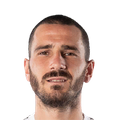

M. Rashford
Power Free-Kick, Flair, Long Shot Taker (AI), Speed Dribbler (AI), Team Player


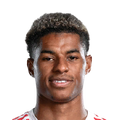

V. van Dijk
Leadership, Long Passer (AI), Power Header


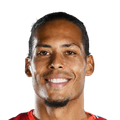

In [26]:
mm_col= client.collections.get("Players_FIFA")

response = mm_col.query.near_text(
    query="Players who are good at Power",
    target_vector="txt_vector",  # Search in the txt_vector space
    limit=3,
    return_metadata=MetadataQuery(distance=True)
)

# Inspect the response
for item in response.objects:
    print(item.properties["short_name"])
    print(item.properties["player_traits"])
    display(load_image(str(item.properties["player_face_url"])))

##### Image Search through Face URL Vector Space

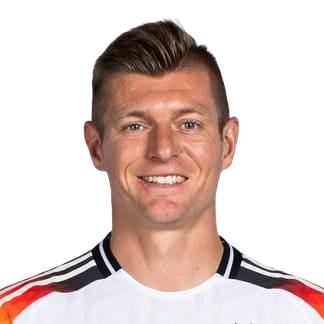

In [27]:
IPYImage("data/test/Kroos.png",width=200)

T. Kroos


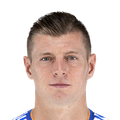

J. Vardy


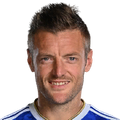

Piqué


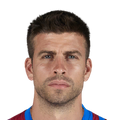

In [28]:
mm_col= client.collections.get("Players_FIFA")

# Perform query
response = mm_col.query.near_image(
    near_image=toBase64_path("data/test/Kroos.png"),
    target_vector="player_face_vector",  # Search in the poster_vector space
    limit=3,
)

from PIL import Image

# Inspect the response
for item in response.objects:
    print(item.properties["short_name"])
    display(load_image(str(item.properties["player_face_url"])))

#### Close Weaviate Client When Done

In [ ]:
client.close()